Saved figure → /sfs/weka/scratch/jbm2rt/DS6050/wildfire-spread-prediction/figures/prev_next_fire_pairs.png


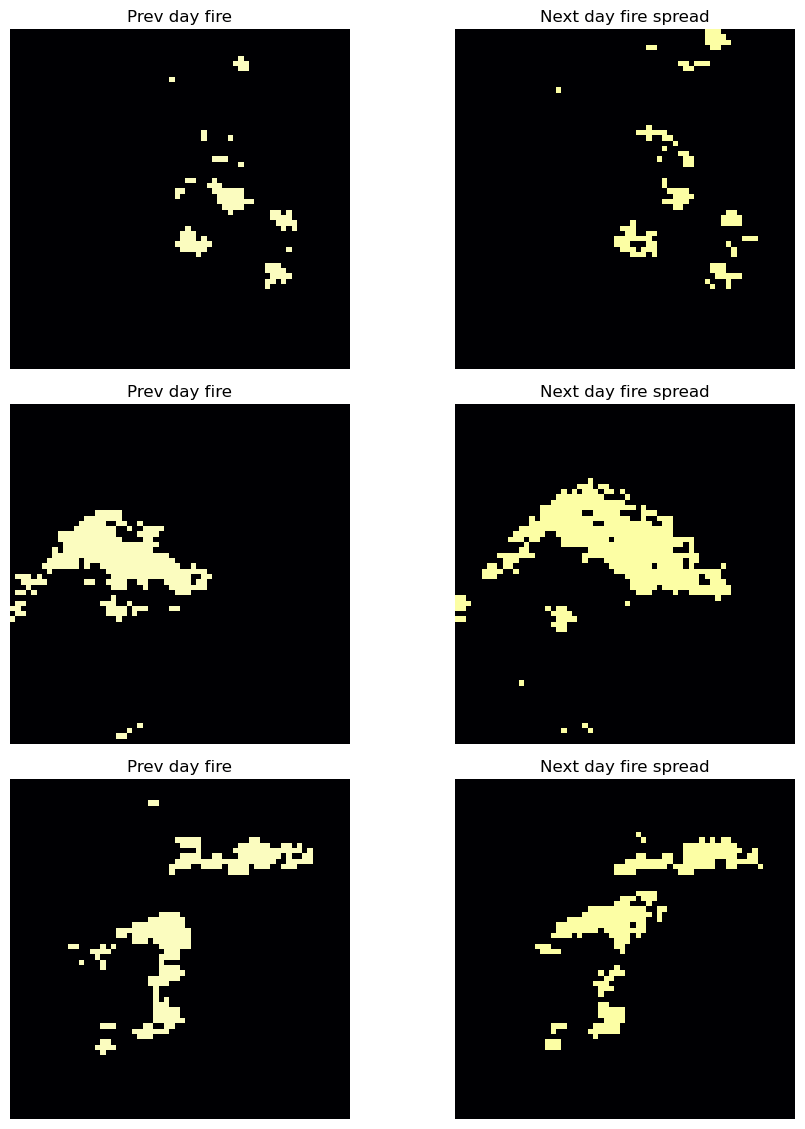

In [5]:
# Prev/next-day fire visualization pairs for presentation
import os
import importlib
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Silence pipeline init logs when possible and load shared DataPipeline helpers
os.environ.setdefault("MNDWS_PIPELINE_SILENT", "1")
pipeline = importlib.import_module("mNDWS_DataPipeline")

val_ds = pipeline.val_ds
channel_names = list(val_ds.channels)
prev_idx = channel_names.index("prev_fire")
rng = np.random.default_rng(2024)
n_samples = min(3, len(val_ds))
sample_indices = rng.choice(len(val_ds), size=n_samples, replace=False)

fig, axes = plt.subplots(n_samples, 2, figsize=(10, 3.8 * n_samples))
if n_samples == 1:
    axes = np.array([axes])

for row, idx in enumerate(sample_indices):
    sample = val_ds[idx]
    prev_fire = sample["X_raw"][prev_idx].numpy()
    next_fire = sample["y"][0].numpy()
    ax_prev, ax_next = axes[row]
    ax_prev.imshow(prev_fire, cmap="magma", vmin=0, vmax=1)
    ax_prev.set_title("Prev day fire")
    ax_prev.axis("off")
    ax_next.imshow(next_fire, cmap="inferno", vmin=0, vmax=1)
    ax_next.set_title("Next day fire spread")
    ax_next.axis("off")

plt.tight_layout()

fig_dir = Path.cwd() / "figures"
fig_dir.mkdir(exist_ok=True)
fig_path = fig_dir / "prev_next_fire_pairs.png"
fig.savefig(fig_path, dpi=300, bbox_inches="tight")
print(f"Saved figure → {fig_path}")

In [2]:
# Baseline metrics when using previous-day fire mask as prediction
import numpy as np
from sklearn.metrics import average_precision_score, precision_recall_curve

test_ds = getattr(pipeline, "test_ds", None)
if test_ds is None:
    raise RuntimeError("pipeline.test_ds is missing; run mNDWS_DataPipeline first.")

def prev_day_baseline_metrics(dataset):
    channel_names = list(dataset.channels)
    if "prev_fire" not in channel_names:
        raise ValueError("Dataset does not contain 'prev_fire' channel.")
    prev_idx = channel_names.index("prev_fire")
    preds, targets = [], []
    for sample in dataset:
        prev_fire = sample["X_raw"][prev_idx].numpy().astype(np.float32).reshape(-1)
        next_fire = sample["y"][0].numpy().astype(np.float32).reshape(-1)
        preds.append(prev_fire)
        targets.append(next_fire)
    probs = np.concatenate(preds)
    truth = np.concatenate(targets)
    if truth.sum() == 0:
        return dict(ap=0.0, f1=0.0, iou=0.0, best_thr=float("nan"))
    ap = float(average_precision_score(truth, probs))
    prec, rec, thr = precision_recall_curve(truth, probs)
    f1_curve = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = int(f1_curve.argmax())
    best_thr = float(thr[best_idx]) if best_idx < len(thr) else 0.5
    binary = (probs >= best_thr).astype(np.float32)
    tp = float((binary * truth).sum())
    fp = float((binary * (1 - truth)).sum())
    fn = float(((1 - binary) * truth).sum())
    iou = tp / (tp + fp + fn + 1e-8)
    return dict(ap=ap, f1=float(f1_curve[best_idx]), iou=float(iou), best_thr=best_thr)

val_metrics = prev_day_baseline_metrics(val_ds)
test_metrics = prev_day_baseline_metrics(test_ds)

print("Prev-mask baseline metrics:")
print(f"  Validation → AP {val_metrics['ap']:.4f} | F1 {val_metrics['f1']:.4f} | IoU {val_metrics['iou']:.4f} | best_thr≈{val_metrics['best_thr']:.3f}")
print(f"  Test        → AP {test_metrics['ap']:.4f} | F1 {test_metrics['f1']:.4f} | IoU {test_metrics['iou']:.4f} | best_thr≈{test_metrics['best_thr']:.3f}")

Prev-mask baseline metrics:
  Validation → AP 0.2098 | F1 0.4393 | IoU 0.2815 | best_thr≈1.000
  Test        → AP 0.1946 | F1 0.4197 | IoU 0.2655 | best_thr≈1.000
